---
title: "Probabilistic programming with Pyro: modeling the forgetting curve"
layout: page
tags: machine learning
categories: blog
comments: true
include_js: ["http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"]
---

In the [previous post](/blog/2020/05/05/flashcard-and-memory.html) of this series we introduced the problem of designing a spaced repetition system, and one crucial aspect was modeling the user's memory. In this post we'll research a model for the user memory using the [pyro](https://pyro.ai/) probabilistic programming library.

To recap: the memory for a certain fact can be modeled as a negative exponential controlled by a parameter `S` that represents how strongly a user is able to retain a certain fact. We can express the probability of correctly recalling a fact as $\theta$, and the outcome as a bernoulli random variable:

$$
\theta = \exp \left(-\frac{t}{S} \right) \\
\textrm{outcome} \sim \textrm{Bernoulli}(\theta)
$$

Pyro is a flexible library designed to perform statistical inference. To give a quick demonstration on how pyro works, we will define a simple probabilistic `model` for a coin toss, i.e. a bernoulli random variable. The bernoulli distribution (among many many others) can be found in the `pyro.distributions` module and to sample from a distribution, we can use the `pyro.sample` function, which returns a pytorch tensor:

In [26]:
import pyro
import pyro.distributions as dist
import torch

# Setting manual seed for reproducibility
torch.manual_seed(43)

def model(theta):
    return pyro.sample("outcome", dist.Bernoulli(probs=theta))

[model(0.3) for _ in range(5)]

[tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.)]

Continuing in our modeling efforts, we will include the negative exponential as a function of `S` in our pyro model. Since `\theta` is a deterministic transformation of `S` the implementation is straightforward. 

To check if our results make sense we can plot the forgetting curve for `S`=30 and see that the probability of correct recall is a bit less than 0.8 at t=10. 

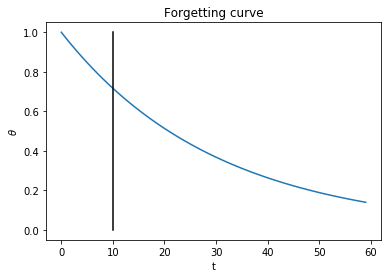

In [27]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0, 60)
plt.plot(t, np.exp(-t/30))
plt.plot([10, 10], [0, 1], color='k')
plt.title("Forgetting curve")
plt.xlabel("t")
plt.ylabel(r"$\theta$");

We can code the example in pyro and simulate what would happen if `S` is 30, and we are trying to remember a fact 10 minutes later as follows:

In [28]:
import numpy as np

def model(t, S):
    """
    t: time in minutes
    S: parameter controlling how well the fact can be recalled (units: minutes)
    """
    theta = np.exp(-t/S)
    return pyro.sample("outcome", dist.Bernoulli(probs=theta))

[model(t=10., S=30.) for _ in range(5)]

[tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.)]

Still, nothing impressive so far. We could have done the exact same thing with a call to `np.random`. 

But what if we want to estimate `S` from data? This is exactly what pyro was designed for. First of all, we can make `S` a random variable itself. Note that `S` is a positive quantity so we can't just make it a normal random variable. For exposition purposes only, we can use a uniform distribution from 0.1 to 1000 (this is called *prior*). The uniform distribution is also part of pyro, and we can easily modify our model by making it sample `S`, obtain a probablity $\theta$, and then sample an outcome:

In [29]:
import numpy as np
import torch

def model(t):
    """
    t: time in minutes
    S: parameter controlling how well the fact can be recalled (units: minutes)
    """
    S = pyro.sample("S", dist.Uniform(0.1, 1000.0))
    theta = torch.exp(-t/S)
    return pyro.sample("outcome", dist.Bernoulli(probs=theta))

[model(t=10.) for _ in range(5)]

[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]

Gathering samples from distribution is not particularly useful, all you get are 0, and 1 with no information regarding the internal state of the model. The thing I like the most about pyro is that its design allows to do things like:
- spy on the values of the random variables inside the model
- fix the value of a random variable inside the model
- [much much more](https://pyro.ai/examples/effect_handlers.html)

Let me show you.

## Tracing

As metioned above, if we execute the model straight up, we only get the final outcome, without any information regarding the other sampled random variables. In pyro, you can use the decorator `trace` to be able to follow the execution. The model can still be executed normally, but can also be executed to obtain a `Trace` boject. A `Trace` object has a `nodes` attribute that contains the value of the intermediate random variables as well as the input and output of the function (and a host of other information).



In [30]:
traced_model = pyro.poutine.trace(model)
# Model can still be used normally
traced_model(t=10)

# Or can be used to obtain a trace
trace = traced_model.get_trace(t=10)
trace.nodes

OrderedDict([('_INPUT',
              {'name': '_INPUT',
               'type': 'args',
               'args': (),
               'kwargs': {'t': 10}}),
             ('S',
              {'type': 'sample',
               'name': 'S',
               'fn': Uniform(low: 0.10000000149011612, high: 1000.0),
               'is_observed': False,
               'args': (),
               'kwargs': {},
               'value': tensor(324.1300),
               'infer': {},
               'scale': 1.0,
               'mask': None,
               'cond_indep_stack': (),
               'done': True,
               'stop': False,
               'continuation': None}),
             ('outcome',
              {'type': 'sample',
               'name': 'outcome',
               'fn': Bernoulli(probs: 0.9696192145347595),
               'is_observed': False,
               'args': (),
               'kwargs': {},
               'value': tensor(1.),
               'infer': {},
               'scale': 1.0,
  

## Conditioning

Now that we have seen how we can spy the values of the random variables in a model, we'll learn how to replace `sample` statements with fixed values, an operation that in statistics is called "conditioning".

To fix `S` to be a certain value, we can use the `pyro.condition` decorator as follows, that's it!

In [31]:
conditioned_model = pyro.condition(model, data={"S": torch.tensor(30.0)})
conditioned_model(t=10.)

tensor(1.)

We can also condition the `outcome` in the same way. Making the model just return 1 all the time (at first sight, I know this doesn't sound particulary useful)

In [32]:
conditioned_model = pyro.condition(model, data={"outcome": torch.tensor(1.0)})
[conditioned_model(t=10.) for _ in range(5)]

[tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)]


# Doing inference with Pyro

Playing around with distribution is pyro is a pleasure, for sure. But how do we estimate `S` from data? There's several methods to do that, for this simple example I'll show the use of markov chain monte carlo inference with the NUTS sampler (for a course on the topic I can recommend the [dog book](https://www.goodreads.com/book/show/9003187-doing-bayesian-data-analysis)). To obtain the estimate for `S` from pyro one needs to:
- Initialize `NUTS` and give it a model that conditions on the outcome. In the example we ask the question: what is the estimated `S` given that the outcome was 0.?
- Initialize the MCMC class by passing the sampler, how many samples we will discard at the beginning of the chain `warmup_steps`, and how many samples to collect `num_samples`.
- Run the model!

At the end you can access the samples from the distribution of `S` (also called *posterior*) using the dictionary returned by `get_samples`. In the following example everything is wrapped into a function, that performs the inference.

Running this code shows that the distribution of `S` is not uniform anymore like we defined initially, but it is concentrated more towards zero.

Sample: 100%|██████████| 384/384 [00:04, 80.80it/s, step size=9.58e-01, acc. prob=0.914]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         S    184.73    261.61     52.05      0.19    646.76    115.50      1.01

Number of divergences: 0


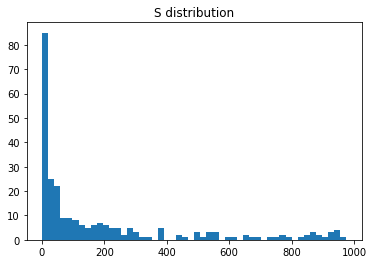

In [33]:
from pyro.infer import MCMC, NUTS
import torch

def run_inference(model, t):
    mcmc_kernel = NUTS(conditioned_model)
    mcmc = MCMC(mcmc_kernel, num_samples=256, warmup_steps=128)
    mcmc.run(t)
    return mcmc

def plot_report(mcmc):
    samples = mcmc.get_samples()
    S = samples['S']
    mcmc.summary()

    # Plot the distribution
    plt.title("S distribution")
    plt.hist(S, bins=50)

conditioned_model = pyro.condition(model, data={"outcome": torch.tensor(0.0)})
mcmc = run_inference(conditioned_model, t=10.0)
plot_report(mcmc)


This all intuitively makes sense! We basically told the model, hey I observed that the user wasn't able to recall the fact at 10 minutes. This simply means that it is less probable for `S` to be much larger than that. But what if the user was, in fact, able to recall an item at t=10? Intuitively, our knowledge shouldn't change much. Let's do this experiment by setting the outcome to be 1.0

Sample: 100%|██████████| 384/384 [00:05, 65.91it/s, step size=1.18e+00, acc. prob=0.812]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         S    512.97    284.22    489.44    105.83    977.94     85.90      1.00

Number of divergences: 0


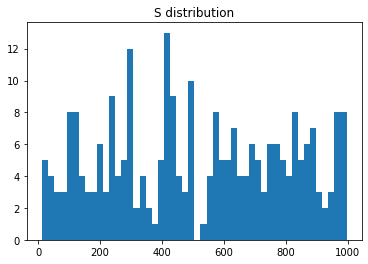

In [34]:
# the outcome observed is 1.0
conditioned_model = pyro.condition(model, data={"outcome": torch.Tensor([1.0])})
mcmc = run_inference(conditioned_model, t=10.0)
plot_report(mcmc)

And it seems to me that S is pretty much uniform between 0.1 and 1000!

In [35]:
conditioned_model = pyro.condition(model, data={"outcome": 1.})
conditioned_model(t=10)

1.0

Nice! We can model a single data point but what if we have multiple data points? We can certainly model that as well but first let's build a simple simulator that represent our users trying to recall a fact.


In [36]:
class UserSimulator:

    def __init__(self, S):
        self._S = S
    
    def recall(self, t):
        theta = torch.exp(-t/self._S)
        return pyro.sample("y", dist.Bernoulli(theta))

sim = UserSimulator(torch.tensor(30.0))
sim.recall(torch.tensor(10.0))

tensor(1.)

We can now use the simulator to build a dataset and perform inference. We first generate 10 data points, uniformly drawn between 1.0 and 100.0

In [37]:
n_sample = 10
data = {"t": torch.rand(n_sample) * 100.0 + 1.0}
data["outcome"] = sim.recall(data["t"])

In our previous implementation of the model, we could only infer `S` from a single data point. Since pyro has broadcasting rules similar to  `pytorch` it is possible to just pass an array and have it magically work.

In [38]:
model(data["t"])

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])

We can then go ahead and do the inference same way as before, this time using the 10 samples instead of 1, and we can plot the distribution.

Sample: 100%|██████████| 384/384 [00:05, 70.58it/s, step size=1.01e+00, acc. prob=0.930]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         S     78.35     48.70     69.31     24.57    130.42    101.74      1.00

Number of divergences: 0


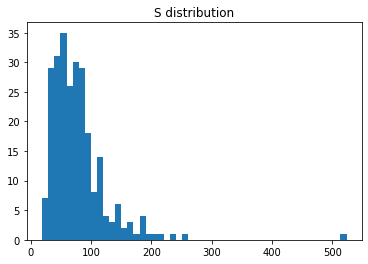

In [39]:
conditioned_model = pyro.condition(model, data={"outcome": data["outcome"]})
mcmc = run_inference(conditioned_model, t=data["t"])
plot_report(mcmc)


I find it amazing how providing about a small sample of 10 data points takes us quite close to the actual value of `S=30.0` that we set in the simulator. Also, we didn't get an individual point estimate but a whole distribution that we can use to estimate other quantities of interest (like possible rewards in a bandit setting).

# Wrap up

That is it for today! In this post we introducted how to use `pyro` to make a very simple statistical model for memory retention. The beauty of the approach lies in its generality: we can play around with any prior and distribution that we like, and then use general methods (like MCMC) for inference. Of course things don't always work out easily but it's an interesting approach nonetheless. 